In [18]:
import os
import yaml
import numpy as np
import scipy
import pandas as pd
from scipy.integrate import simps
import  matplotlib.pyplot as plt
from rubin_calib_etc import RubinCalibETC

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LED

In [101]:
TPUT_DIR = './baseline_tput_curves'

In [102]:
config_file = os.path.join('config','led_ff_calib_etc_10122023.yaml')

In [103]:
with open(config_file) as f:
    config = yaml.safe_load(f)
    print(config)

{'light_source': 'LED', 'calib_type': 'Flatfield', 'LEDS': {'u': ['M385L3'], 'g': ['M455L4', 'M505L4'], 'r': ['M565L3', 'M660L4'], 'i': ['M730L5', 'M780LP1'], 'z': ['M850LP1', 'M940L3'], 'y4': ['M970L4']}, 'dichroic_files': {'u': 'DMLP735B_RawData.csv', 'i': 'curv_69904.csv', 'g': 'DMLP490.csv', 'r': 'DMLP605.csv', 'z': 'DMLP900.csv', 'y4': 'DMLP735B_RawData.csv'}, 'coating_type': {'u': 'A', 'g': 'A', 'r': 'A', 'i': 'B', 'z': 'B', 'y4': 'B'}, 'snr': 1000, 'use_fiber': False, 'f_lsst': 10.3, 'pixel_size': 1e-05, 'm1': 'Protected-Ag', 'm2': 'Protected-Ag', 'm3': 'Protected-Ag', 'detector_file': 'detector_e2vPrototype.dat', 'corrector_lenses': ['lens1.dat', 'lens2.dat', 'lens3.dat'], 'total_number_of_pixels': 3200000000, 'cam_readout': 2, 'min_exptime': 13, 'electrometer_readout': 0, 'spectrograph_readout': 0, 'projector_design': ['collimator', 'mirror_al_f01', 'converging_bk7', 'converging_bk7', 'converging_bk7'], 'system_efficiency': 0.00010959, 'reflector_reflectance_file': 'scaled_ref

In [104]:
ETC = RubinCalibETC(config_file)

In [38]:
ETC.led_output()

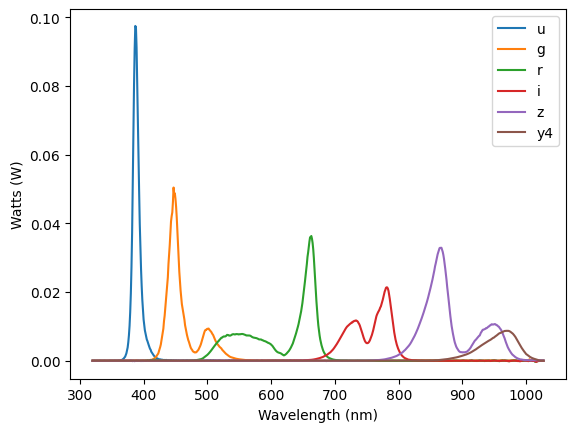

In [39]:
for filter, output in ETC.led_flux.items():
    plt.plot(ETC.rubin_wavelength, output, label=filter)
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Watts (W)")
plt.savefig('whitelight_source_flux.png')

### Plots

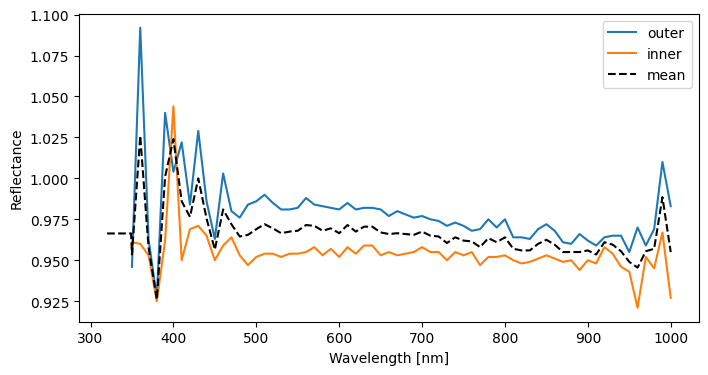

In [26]:
plt.figure(figsize=(8,4))
refl = []
for filen in ETC.screen_reflectance_files:
    df = pd.read_csv(os.path.join(TPUT_DIR, filen))
    plt.plot(df.Wavelength, df.Reflectance/100.,label=filen.split('_')[1])
    f = scipy.interpolate.interp1d(df.Wavelength, df.Reflectance/100.,bounds_error=False,fill_value=np.mean(df.Reflectance/100.))
    refl.append(f(ETC.rubin_wavelength))

plt.plot(ETC.rubin_wavelength, np.mean(refl, axis=0), 'k--',label='mean')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance')
plt.legend()
plt.savefig('screen_reflectance.png')

In [8]:
df_reflector = pd.read_csv(os.path.join(TPUT_DIR,'reflector_reflectance.csv'))
df_reflector.head()
print(df_reflector.columns)

Index(['Wavelength', 'OD Scan', 'Left Scan', 'Vertical Scan'], dtype='object')


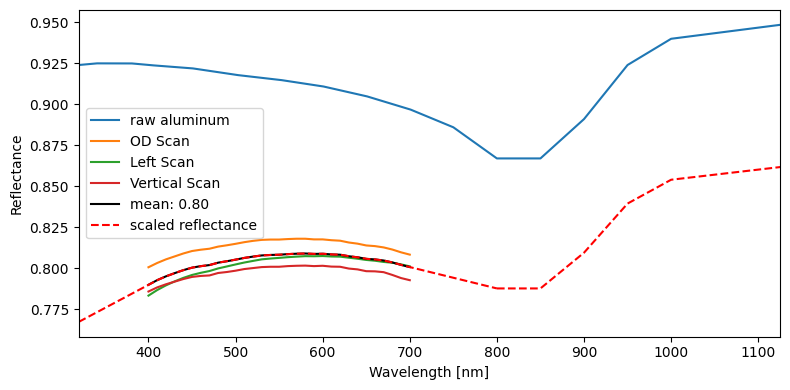

In [10]:
plt.figure(figsize=(8,4))
total_refl = []
plt.plot(ETC.rubin_wavelength, refl, label='raw aluminum')
for col in ['OD Scan', 'Left Scan', 'Vertical Scan']:
    plt.plot(df_reflector.Wavelength, df_reflector[col]/100., label=col)
    total_refl.append(df_reflector[col])
plt.plot(df_reflector.Wavelength, np.mean(total_refl,axis=0)/100., 'k',label=f'mean: {np.mean(np.mean(total_refl,axis=0))/100.:.2f}')
g = scipy.interpolate.interp1d(df_reflector.Wavelength, np.mean(total_refl,axis=0)/100., bounds_error=False, fill_value='extrapolate')
range_ = np.linspace(320, 800, (800-320)+1)
plt.plot(range_,g(range_),'r--')
b = g(800)/f(800)
range_2 = np.linspace(800, 1200, (1200-800)+1)
plt.plot(range_2, f(range_2)*b, 'r--',label='scaled reflectance')
plt.legend()
plt.xlim(320, 1125)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance')
plt.tight_layout()
plt.savefig('reflector_reflectance.png')

In [11]:
c = np.hstack([g(range_),f(range_2)[1:]*b])
wave = np.linspace(320, 1200, (1200-320)+1)
df = pd.DataFrame()
df['Wavelength'] = wave
df['Reflectance'] = c
df.to_csv('scaled_reflector_reflectance.csv',index=False)

In [12]:
plt.figure(figsize=(8,4))
plt.plot(ETC.rubin_wavelength, ETC.corrector_thoughtput)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission')
plt.title('Collimating Lenses Transmission')
plt.tight_layout()
plt.savefig('collimator_trans.png')

AttributeError: 'RubinCalibETC' object has no attribute 'corrector_thoughtput'

<Figure size 800x400 with 0 Axes>

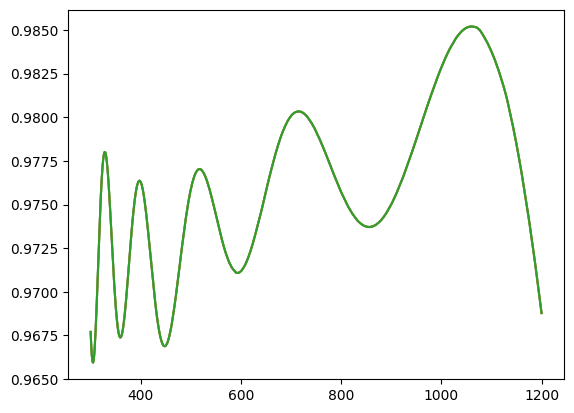

In [13]:
for filen in ETC.corrector_lenses:
    df = pd.read_csv(os.path.join(TPUT_DIR, filen),skiprows=2,delim_whitespace=True,
                            names=['Wavelength', 'Transmission'])
    plt.plot(df.Wavelength, df.Transmission)

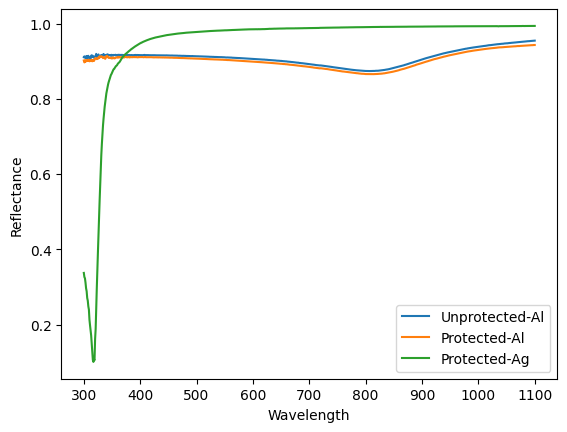

In [34]:
df = pd.read_csv(os.path.join(TPUT_DIR, ETC.mirror_file),skiprows=1,names=['Wavelength','Unprotected-Al','Protected-Al','Protected-Ag'])
for mirror in ['Unprotected-Al', 'Protected-Al', 'Protected-Ag']:
    plt.plot(df.Wavelength, df[mirror]/100., label=mirror)
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.legend()
plt.savefig('mirror_coating_reflectance.png')

### Run the ETC

In [105]:
ETC = RubinCalibETC(config_file)
ETC.get_photons_per_pixel()

Text(0.5, 0, 'Wavelength (nm)')

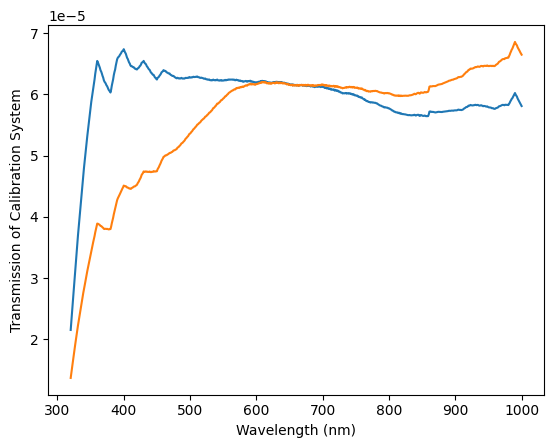

In [106]:
plt.plot(ETC.rubin_wavelength, ETC.total_flatfield_optics_tput['u'], label='A coated collimating lens')
plt.plot(ETC.rubin_wavelength, ETC.total_flatfield_optics_tput['z'], label='B coated collimating lens')
plt.ylabel('Transmission of Calibration System')
plt.xlabel('Wavelength (nm)')

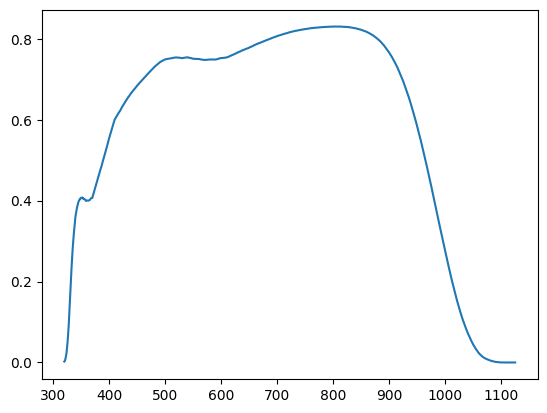

In [107]:
lsst_optics = ETC.telescope_reflectance * ETC.detector_efficiency * ETC.corrector_thoughtput
plt.plot(ETC.rubin_wavelength, lsst_optics)

{'u': 79.50927527000539,
 'g': 23.912816698014655,
 'r': 18.717560455651974,
 'i': 17.786972436026506,
 'z': 15.0,
 'y4': 44.42611963331471}

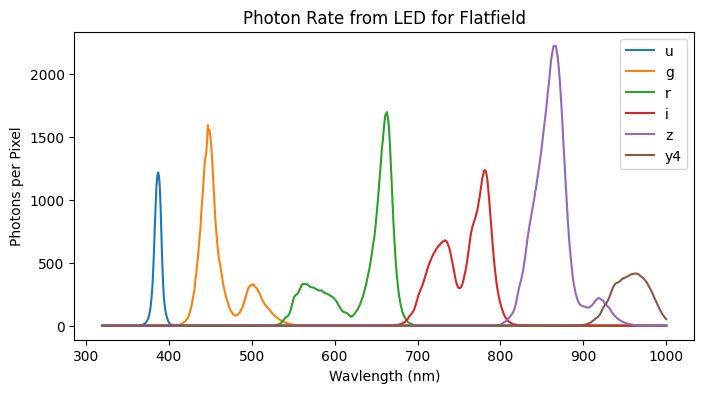

In [108]:
ETC.get_total_exptime()
ETC.plot_photon_rate()
plt.savefig('led_ff_photon_rate.png')
ETC.total_exptimes

In [109]:
TPUT = {}
for filter_ in ETC.total_exptimes.keys():
    total_tput = ETC.total_flatfield_optics_tput[filter_]* ETC.tel_cam_system_tput[filter_]
    TPUT[filter_] = total_tput

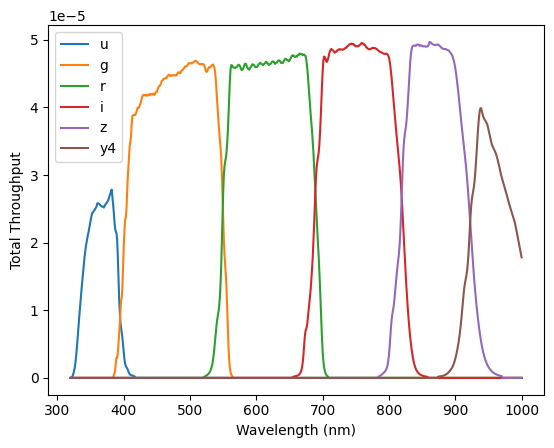

In [110]:
for filt, tput in TPUT.items():
    plt.plot(ETC.rubin_wavelength, tput, label=filt)
    df = pd.DataFrame()
    df['Wavelength[nm]'] = ETC.rubin_wavelength
    df['Throughput'] = tput
    df.to_csv(f'calibration_tput_init_{filt}.csv', index=False)
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Total Throughput')
plt.savefig('led_ff_total_tput.png')

In [57]:
ETC.total_exptimes #seconds

{'u': 79.50927527000539,
 'g': 23.912816698014655,
 'r': 18.717560455651974,
 'i': 17.786972436026506,
 'z': 15.0,
 'y4': 44.42611963331471}

In [58]:
ETC.filters

{'u': [324, 395.0],
 'g': [405, 552],
 'r': [552, 691],
 'i': [691, 818],
 'z': [818, 921],
 'y4': [922, 997]}

In [59]:
#Integrated Photon Rates
for filter_name, ph in ETC.photons_per_pixel.items():
    filter_wave = np.linspace(ETC.filters[filter_name][0], ETC.filters[filter_name][1], 
                              int(ETC.filters[filter_name][1]-ETC.filters[filter_name][0]) + 1)
    f = scipy.interpolate.interp1d(ETC.rubin_wavelength, ph)
    integrated_ph_count = simps(f(filter_wave), filter_wave)
    print(filter_name, integrated_ph_count)

u 12439.388817584333
g 45580.46174922627
r 57927.51440295545
i 62808.1692577408
z 89436.08470898503
y4 22409.143231221668


In [30]:
#Integrated Photon Rates
for filter_name, ph in ETC.photons_per_pixel.items():
    filter_wave = np.linspace(ETC.filters[filter_name][0], ETC.filters[filter_name][1], 
                              int(ETC.filters[filter_name][1]-ETC.filters[filter_name][0]) + 1)
    f = scipy.interpolate.interp1d(ETC.rubin_wavelength, ph)
    integrated_ph_count = simps(f(filter_wave), filter_wave)
    print(filter_name, integrated_ph_count)

u 11455.566413164579
g 42054.386427155376
r 53139.8807810299
i 56668.73845321706
z 81205.43698144505
y4 21244.23920539516


## Laser

In [111]:
config_file = os.path.join('config','laser_ff_calib_etc_10122023.yaml')
ETC = RubinCalibETC(config_file)

In [112]:
with open(config_file) as f:
    config = yaml.safe_load(f)
    print(config)

{'light_source': 'laser', 'calib_type': 'Flatfield', 'snr': 100, 'laser_power_file': 'PGD151_NT242.txt', 'laser_decrease_expected': 0, 'use_fiber': True, 'fiber_length': 15, 'fiber_coupling': 0.8, 'fiber_type': 'WFNS', 'f_lsst': 10.3, 'pixel_size': 1e-05, 'm1': 'Protected-Ag', 'm2': 'Protected-Ag', 'm3': 'Protected-Ag', 'detector_file': 'detector_e2vPrototype.dat', 'corrector_lenses': ['lens1.dat', 'lens2.dat', 'lens3.dat'], 'total_number_of_pixels': 3200000000, 'cam_readout': 2, 'min_exptime': 13, 'electrometer_readout': 0, 'spectrograph_readout': 0, 'projector_design': ['converging_uvfs', 'converging_uvfs', 'converging_bk7', 'converging_bk7'], 'system_efficiency': 5.7377e-05, 'reflector_reflectance_file': 'scaled_reflector_reflectance.csv'}


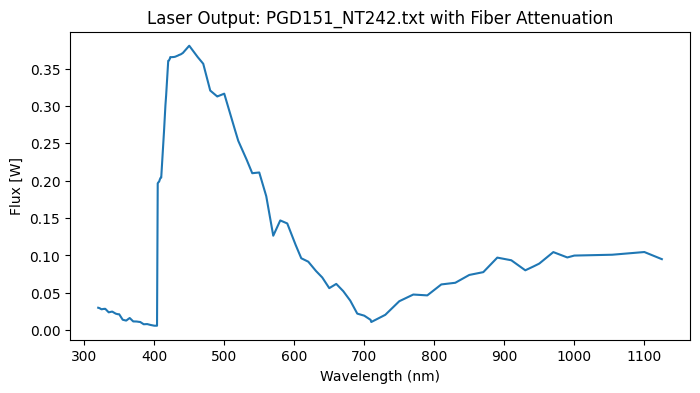

In [113]:
ETC.plot_lightsource_output(fiber_plot=False)

In [114]:
ETC = RubinCalibETC(config_file)
ETC.get_photons_per_pixel()

In [115]:
ETC.get_total_exptime()
ETC.total_exptimes

{'u': 13056.886043605826,
 'g': 2220.0,
 'r': 2181.5070399380884,
 'i': 2320.897319653668,
 'z': 1560.0,
 'y4': 1140.0}

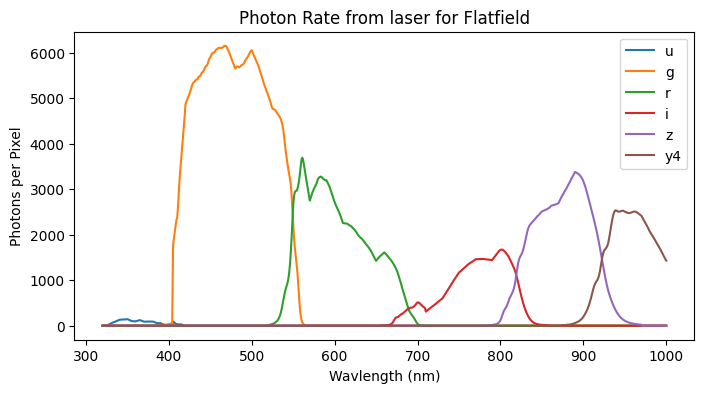

In [116]:
ETC.plot_photon_rate()
plt.savefig('laser_ff_photon_rate.png')

In [117]:
TPUT = {}
for filter_ in ETC.total_exptimes.keys():
    total_tput = ETC.total_flatfield_optics_tput[filter_]* ETC.tel_cam_system_tput[filter_]
    TPUT[filter_] = total_tput

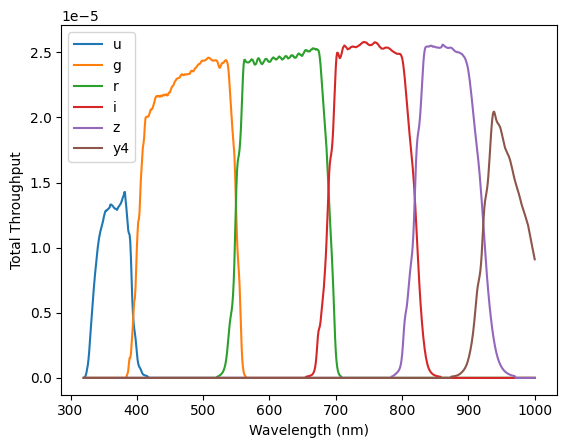

In [118]:
for filt, tput in TPUT.items():
    plt.plot(ETC.rubin_wavelength, tput, label=filt)
    df = pd.DataFrame()
    df['Wavelength[nm]'] = ETC.rubin_wavelength
    df['Throughput'] = tput
    #df.to_csv(f'calibration_tput_init_{filt}.csv', index=False)
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Total Throughput')
plt.savefig('laser_ff_total_tput.png')

In [93]:
total_time = 0
for filter_name, total in ETC.total_exptimes.items():
    print(filter_name, total/60.)
    total_time += total/60.

u 217.61476739343044
g 37.0
r 36.358450665634805
i 38.681621994227804
z 26.0
y4 19.0


In [94]:
total_time/60.

6.2442473342215505

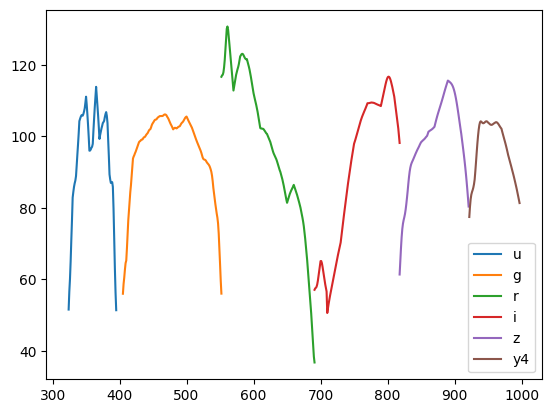

In [213]:
#For laser
for filter_name, ph in ETC.photons_per_pixel.items():
    filter_wave = np.linspace(ETC.filters[filter_name][0], ETC.filters[filter_name][1], 
                              int(ETC.filters[filter_name][1]-ETC.filters[filter_name][0]) + 1)
    f = scipy.interpolate.interp1d(ETC.rubin_wavelength, ph)
    med_ph_rate = np.median(f(filter_wave))
    med_exptime = ETC.get_exptime(med_ph_rate, 100)
    med_snr = ETC.get_snr(f(filter_wave), med_exptime)
    plt.plot(filter_wave, med_snr, label=f'{filter_name}')
plt.legend()

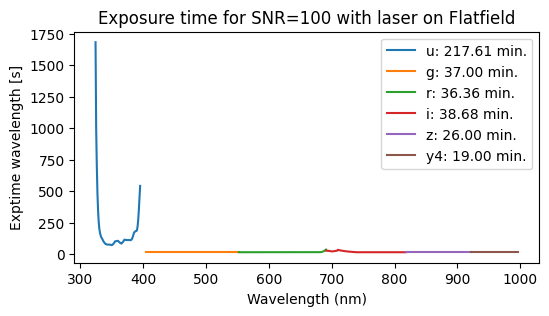

In [119]:
ETC.plot_exptime()
#plt.ylim(0,100)
plt.savefig('laser_ff_totalexptime.png')

In [215]:
ETC.m1 = 'Al-Ideal'
ETC.m3 = 'Al-Ideal'

In [216]:
ret = ETC.get_total_exptime()

In [217]:
for filter_name, total in ETC.total_exptimes.items():
    print(f'{filter_name}: {total/60.:.2f}')

u: 48.56
g: 37.00
r: 35.00
i: 32.00
z: 26.00
y4: 19.00


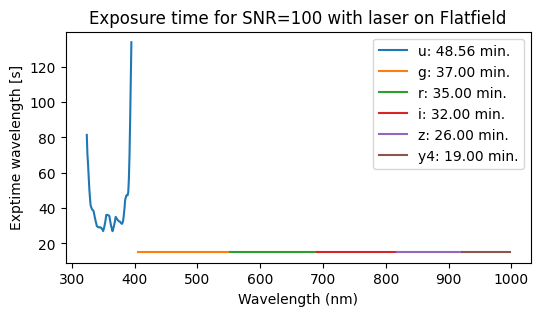

In [218]:
ETC.plot_exptime()
plt.savefig('laser_ff_totalexptime_Al.png')

In [ ]:
#10 minute difference in u band. no more than 4 hours for 1nm steps through a filter.